# **Sistemas de Recomendação de Filmes**

Por **Gustavo Andrade Tavares**

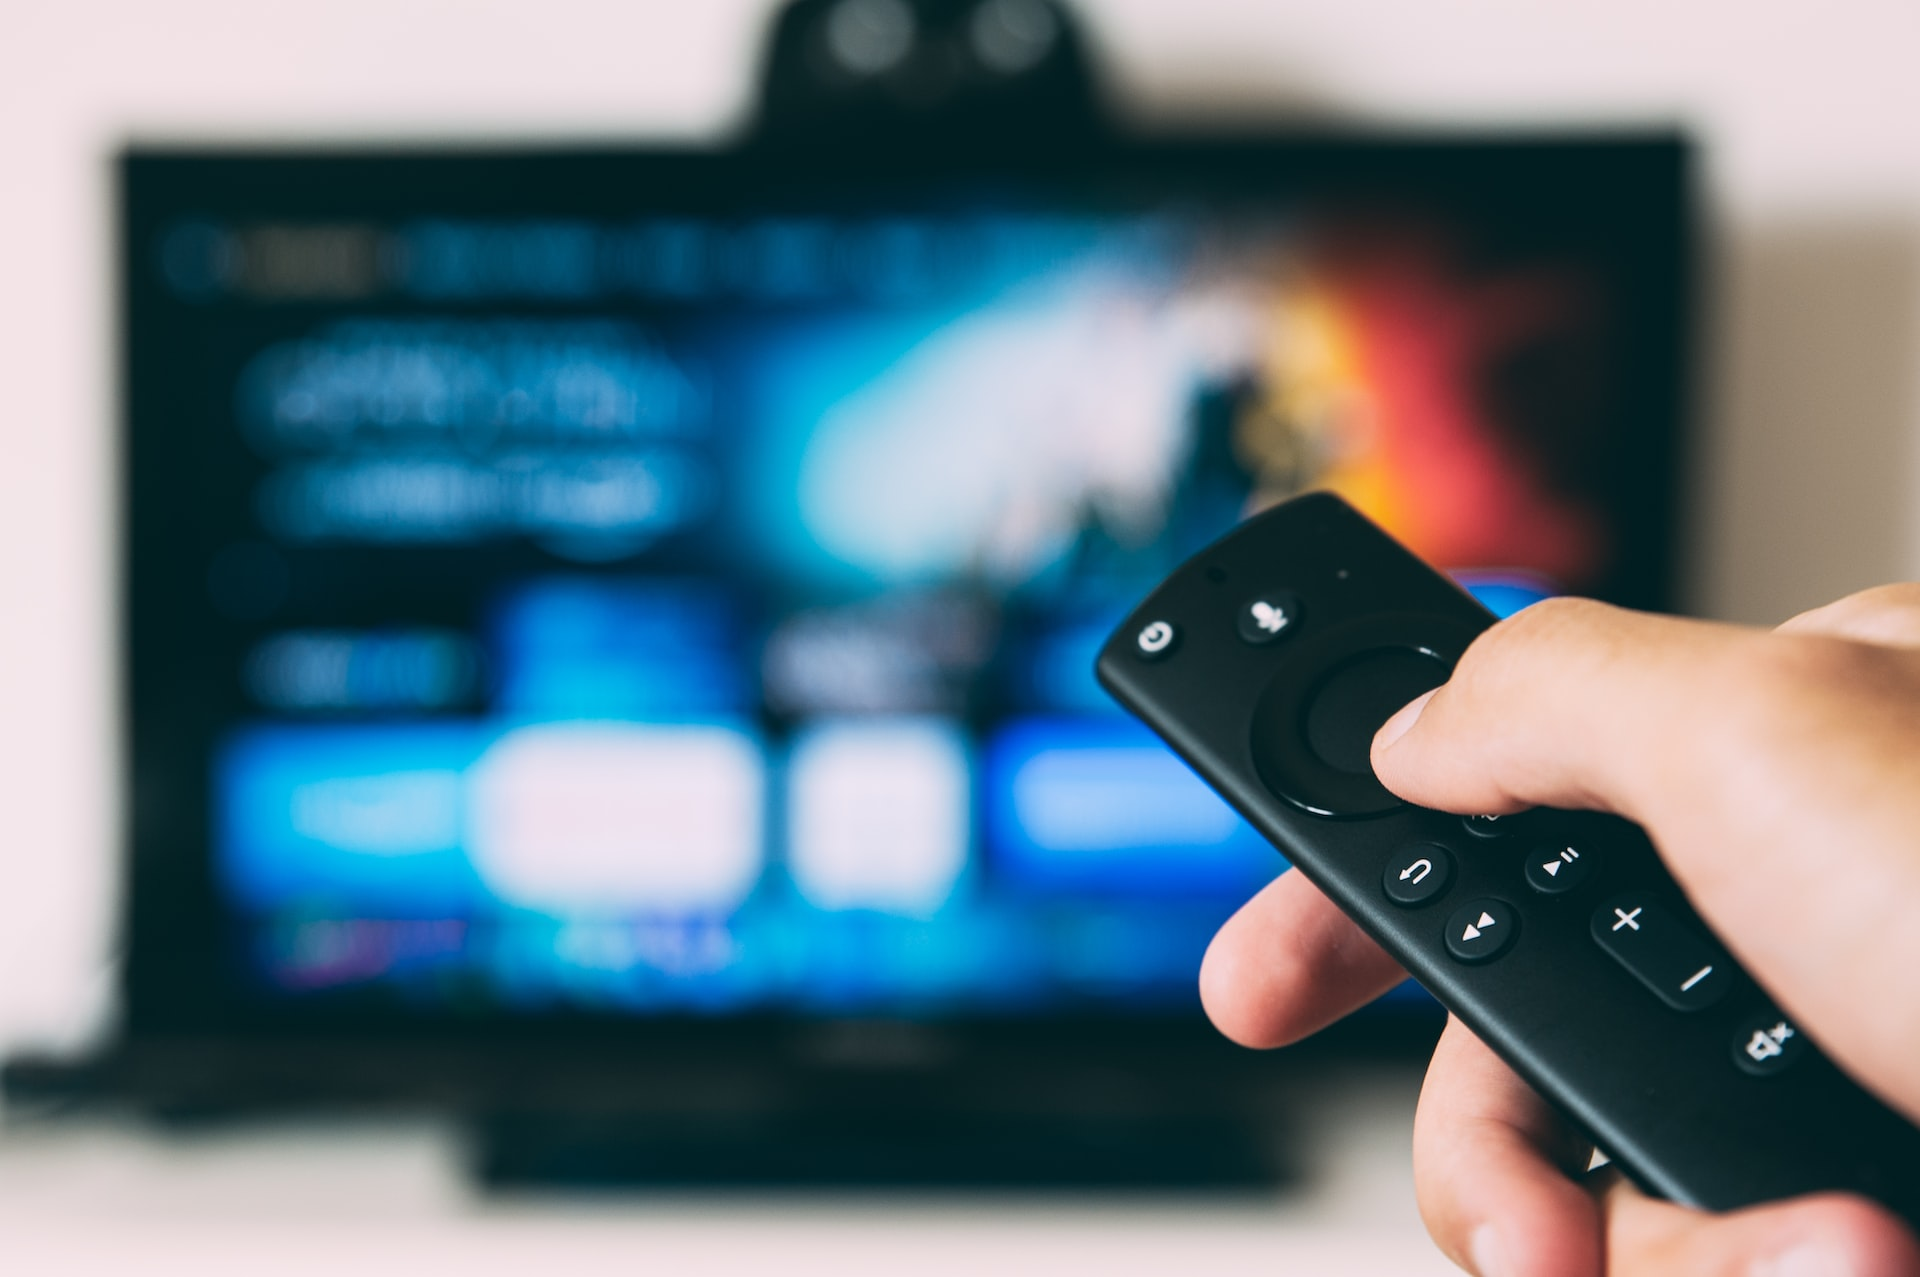

Foto de <a href="https://unsplash.com/@glenncarstenspeters?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Glenn Carstens-Peters</a> na <a href="https://unsplash.com/pt-br/fotografias/EOQhsfFBhRk?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## **1) Introdução**

O objetivo deste trabalho é implementar um sistema de recomendação de filmes. 

Para isso, utiliza-se dois conjuntos de dados: um que contém os filmes e os seus respectivos gêneros, e outro dataset contendo as avaliações dos usuários.

Link para o download dos dados: [moviedataset.zip](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip)

Para mais informações sobre os dados: [GroupLens](http://grouplens.org/datasets/movielens/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01).




O dataset `movies.csv` contém as seguintes variáveis:



*   movieID
*   title
*   genres



O dataset `ratings.csv` contém as variáveis:



*   userID
*   movieID
*   rating
*   timestamp



Sendo assim, utiliza-se os métodos de recomendação: Content-Based e Collaborative filtering.

## **2) Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## **3) Abertura dos dados**

In [2]:
df_movies = pd.read_csv("/content/drive/MyDrive/Arquivos_Colab/Projetos/Dados/Movies/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  34208 non-null  int64 
 1   title    34208 non-null  object
 2   genres   34208 non-null  object
dtypes: int64(1), object(2)
memory usage: 801.9+ KB


In [3]:
df_ratings = pd.read_csv("/content/drive/MyDrive/Arquivos_Colab/Projetos/Dados/Movies/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 698.4 MB


### **3.1) Preparação do conjunto de dados movies**

Inicialmente, separa-se em outra coluna, o ano do título do filme:

In [4]:
df_movies['year'] = df_movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Remove os parênteses
df_movies['year'] = df_movies.year.str.extract('(\d\d\d\d)',expand=False)
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Agora, remove-se o ano da variável `title`

In [5]:
df_movies['title'] = df_movies.title.str.replace('(\(\d\d\d\d\))', '')
df_movies['title'] = df_movies['title'].apply(lambda x: x.strip())
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Para facilitar a manipulação, transforma-se as observações da variável `genre` como uma lista, com o comando `split('|')`:

In [6]:
# transformar em lista os elementos de genre
df_movies['genres'] = df_movies.genres.str.split('|')
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Agora, utiliza-se One Hot Encoding para transformar cada gênero como uma variável, que assume valor 0 caso o filme não tem o gênero e 1 para o caso que o filme tem o gênero em questão:

In [7]:
#Cópia do dataset
df_movies_genres = df_movies.copy()

# iteracao sobre a lista de generos e coloca 1 na coluna do respectivo genero
for index, row in df_movies.iterrows():
    for genre in row['genres']:
        df_movies_genres.at[index, genre] = 1
# preenche os elementos vazios com zero
df_movies_genres = df_movies_genres.fillna(0)
df_movies_genres.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_movies_genres.year = df_movies_genres.year.astype(int)

In [ ]:
df_movies_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             34208 non-null  int64  
 1   title               34208 non-null  object 
 2   genres              34208 non-null  object 
 3   year                34208 non-null  int64  
 4   Adventure           34208 non-null  float64
 5   Animation           34208 non-null  float64
 6   Children            34208 non-null  float64
 7   Comedy              34208 non-null  float64
 8   Fantasy             34208 non-null  float64
 9   Romance             34208 non-null  float64
 10  Drama               34208 non-null  float64
 11  Action              34208 non-null  float64
 12  Crime               34208 non-null  float64
 13  Thriller            34208 non-null  float64
 14  Horror              34208 non-null  float64
 15  Mystery             34208 non-null  float64
 16  Sci-

### **3.2) Preparação do conjunto de dados ratings**

Removendo-se a variável `timestamp` para economizar espaço, uma vez que, não é importante:

In [9]:
df_ratings = df_ratings.drop(df_ratings.columns[[3]], axis = 1)
df_ratings.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 523.8 MB


## **4) Visualização e Exploração dos Dados**

### **4.1) Movies**

Inicialmente, verifica-se os anos de lançamento dos filmes:

In [ ]:
anos = df_movies_genres.year.to_numpy()
print("Anos:")
print(np.unique(anos))
print("Quantidade: ", len(np.unique(anos)))

Anos:
[   0 1874 1878 1887 1888 1890 1891 1892 1893 1894 1895 1896 1897 1898
 1899 1900 1901 1902 1903 1904 1905 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016]
Quantidade:  130


Assume-se que há dados faltantes, pois há observações com ano "zero".

Analisando-se a quantidade de filmes dos anos 2000 até 2016, temos:

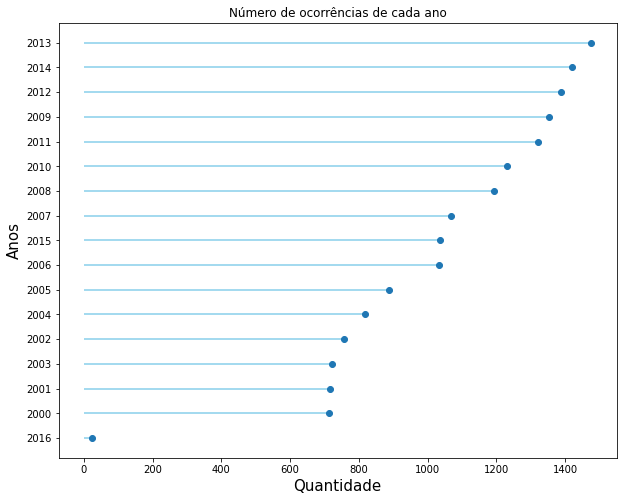

In [ ]:
l = anos.tolist()
ultimos_anos = [int(x) for x in range(2000,2017)]
qtd_filmes = []

for i in range(2000,2017):
  qtd_filmes.append(l.count(i))


df = pd.DataFrame({'Anos': ultimos_anos, 'Quantidade': qtd_filmes})

# Reorder it based on the values
ordered_df = df.sort_values(by='Quantidade')
my_range=range(1,len(df.index)+1)
 
# The horizontal plot is made using the hline function
plt.figure(figsize=(10,8))
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Quantidade'], color='skyblue')
plt.plot(ordered_df['Quantidade'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['Anos'])
plt.title("Número de ocorrências de cada ano")
plt.xlabel('Quantidade',fontsize = 15)
plt.ylabel('Anos',fontsize = 15)

# Show the plot
plt.show()

Para visualizar os filmes dos respectivos anos, é possível filtrar o conjunto de dados. Como por exemplo, para o ano de 2016, que têm poucos filmes:

In [ ]:
df_2016 = df_movies_genres[(df_movies_genres['year'] == 2016)]

filmes_2016 = df_2016.title.to_numpy()
for i in range(len(filmes_2016)):
  print(filmes_2016[i])

Avatar 2
13 Hours
Colonia
The 5th Wave
Kung Fu Panda 3
Quo vado?
The Forest
Sherlock: The Abominable Bride
Band of Robbers
Army Dog
The Correspondence
Wiener-Dog
Norm of the North
Ride Along 2
Notias
Airlift
Exposed
Martyrs
Lo and Behold: Reveries of the Connected World
Jättiläinen
JeruZalem
Lazer Team
Risen


Agora, analisando-se a quantidade de filmes com os seguintes gêneros: 

* Adventure
* Animation
* Comedy
* Romance
* Drama
* Action
* Horror
* Sci-Fi
* Documentary
* Musical

segue que:

In [ ]:
adv = df_movies_genres.Adventure.to_numpy()
anm = df_movies_genres.Animation.to_numpy()
cmd = df_movies_genres.Comedy.to_numpy()
rmc = df_movies_genres.Romance.to_numpy()
drm = df_movies_genres.Drama.to_numpy()
act = df_movies_genres.Action.to_numpy()
hrr = df_movies_genres.Horror.to_numpy()
scf = df_movies_genres['Sci-Fi'].to_numpy()
dcm = df_movies_genres.Documentary.to_numpy()
mus = df_movies_genres.Musical.to_numpy()

qtd = [sum(adv), sum(anm), sum(cmd), sum(rmc), sum(drm), sum(act), sum(hrr), sum(scf), sum(dcm), sum(mus)]
gen = ['Adventure', 'Animation','Comedy', 'Romance', 'Drama','Action', 'Horror', 'Sci-Fi', 'Documentary', 'Musical']

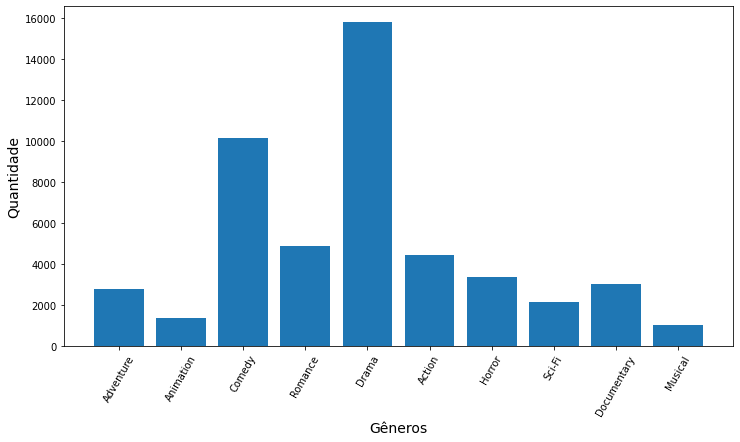

In [ ]:
x_pos = np.arange(len(gen))
# Create bars

plt.figure(figsize=(12,8))
plt.bar(x_pos, qtd)
# Rotation of the bar names
plt.xticks(x_pos, gen, rotation=60)
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.xlabel("Gêneros", fontsize=14)
plt.ylabel("Quantidade", fontsize=14) 
plt.show()

Observa-se que o gênero Drama está presente na maioria dos filmes do conjunto de dados, e em seguida, Comedy.

### **4.2) Ratings**

In [ ]:
# Transformando-se os dados para Numpy
rating = df_ratings.rating.to_numpy()

In [ ]:
print("Valor mínimo de avaliações: ",min(rating))
print("Valor máximo de avaliações: ",max(rating))
print("Quantidade de avaliações: ", len(rating))

Valor mínimo de avaliações:  0.5
Valor máximo de avaliações:  5.0
Quantidade de avaliações:  22884377


In [ ]:
print("Valores únicos: ", np.unique(rating))

Valores únicos:  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


Observando-se o histograma de `ratings`, temos:

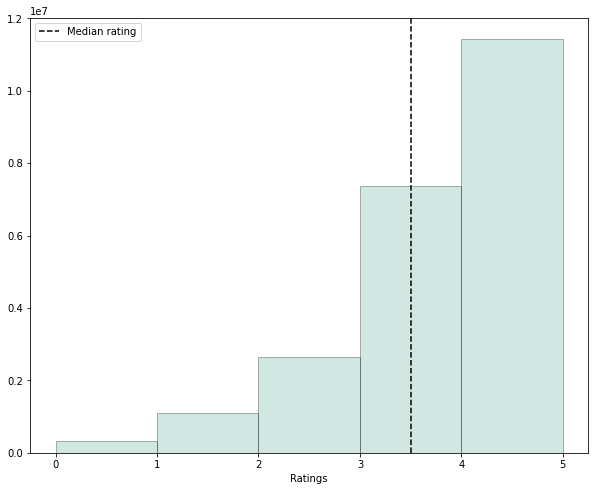

In [ ]:
median_rating = np.median(rating)
bins = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(rating, bins=bins, edgecolor="black", color="#69b3a2", alpha=0.3)

# axvline: axis vertical line
ax.axvline(median_rating, color="black", ls="--", label="Median rating")
plt.xlabel("Ratings")
ax.legend();

Ou seja, nota-se que a maioria dos usuários avaliam filmes com $4$, $4.5$ e $5$.

## **5) Sistemas de Recomendação**

Considere que um determinado usuário avaliou os seguintes filmes:

In [10]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':5},
            {'title':'Kung Fu Panda 3', 'rating':3.5},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,5.0
2,Kung Fu Panda 3,3.5
3,Pulp Fiction,5.0
4,Akira,4.5


Adicionando-se a variável `movieID`, temos:

In [11]:
# Filtrar o dataset de acordo com os filmes avaliados do usuario
inputId = df_movies[df_movies['title'].isin(inputMovies['title'].tolist())]
inputId

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985
33654,149406,Kung Fu Panda 3,"[Action, Adventure, Animation]",2016


In [12]:
# Juntando os conjuntos de dados de acordo com o titulo
inputMovies = pd.merge(inputId, inputMovies)
inputMovies

,movieId,title,genres,year,rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5.0
1,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,5.0
2,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,4.5
3,1968,"Breakfast Club, The","[Comedy, Drama]",1985,5.0
4,149406,Kung Fu Panda 3,"[Action, Adventure, Animation]",2016,3.5


Eliminando-se as variáveis desnecessárias, temos:

In [13]:
# Eliminar variaveis 
inputMovies = inputMovies.drop(inputMovies.columns[[2,3]], axis = 1)
inputMovies

,movieId,title,rating
0,1,Toy Story,5.0
1,296,Pulp Fiction,5.0
2,1274,Akira,4.5
3,1968,"Breakfast Club, The",5.0
4,149406,Kung Fu Panda 3,3.5


### **5.1) Content-Based filtering**

Basicamente, Content-Based ou item-item recommendation systems, é uma técnica para analisar as preferências do usuário de um item e, depois, fazer a recomendação de itens parecidos em relação às preferências do usuário. No caso, o objetivo é fazer recomendação de filmes.

**Por exemplo:** Considera-se que há 6 filmes com gêneros parecidos e, o usuário avaliou os filmes 1, 2 e 3. Assim, para recomendar algum dos filmes 4, 5 e 6, é necessário fazer alguns cálculos para obter um score de cada filme e recomendar os filmes que têm os maiores scores.

Suponha que o usuário avaliou os filmes 1, 2 e 3 com os seguintes valores:

$$
ratings = 
\begin{bmatrix}
2 \\
5 \\
3
\end{bmatrix}
$$

Ou seja, o filme 1 recebeu avaliação 2, o filme 2 recebeu 5 e o filme 3 recebeu 3.


Obtém-se os gêneros dos filmes, por meio de uma matriz de variáveis indicadoras:

$$
genre = 
\begin{bmatrix}
0 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 \\
1 & 0 & 1 & 0
\end{bmatrix}
$$

Isto é, cada coluna representa um determinado gênero, e cada linha representa um filme. Assim, o filme 1 têm os gêneros 2 e 3, o filme 2 têm todos os gêneros e o filme 3 têm os gêneros 1 e 3. 



Para obter os pesos de cada gênero, utiliza-se os valores de `ratings` da seguinte forma: Como o filme 1 recebeu avaliação 2, então multiplica-se a linha da matriz `genre` por esta avaliação. O filme 2 recebeu avaliação 5 e, assim, multiplica-se a linha por este valor e assim sucessivamente para todas as linhas:

$$
weighted\_genre = 
\begin{bmatrix}
0 & 2 & 2 & 0 \\
5 & 5 & 5 & 5 \\
3 & 0 & 3 & 0
\end{bmatrix}
$$

Logo, obtém-se os pesos dos gêneros 1, 2, 3 e 4 ao somar as colunas da matriz `weighted_genre` e faz-se a normalização:


$$
user\_profile = 
\begin{bmatrix}
8 & 7 & 10 & 5 \\
\end{bmatrix}
= 
\begin{bmatrix}
0.27 & 0.23 & 0.33 & 0.17 \\
\end{bmatrix}
$$

Em relação aos filmes que o usuário não assistiu, obtém-se os gêneros dos filmes 4, 5 e 6:

$$
genre = 
\begin{bmatrix}
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 1 & 0
\end{bmatrix}
$$


Multiplica-se cada coluna da matriz `genre` de acordo com os pesos de cada gênero do vetor `user_profile`:


$$
weighted\_genre =
\begin{bmatrix}
0.27 & 0.23 & 0 & 0.17 \\
0 & 0 & 0.33 & 0 \\
0.27 & 0 & 0.33 & 0
\end{bmatrix}
$$

Ao fazer a soma das entradas da matriz resultante, obtém-se os scores e, assim, é possível estimar os valores de avaliações do usuário para os filmes 4, 5 e 6, e fazer a recomendação dos filmes com os maiores valores:

$$
scores = 
\begin{bmatrix}
0.67 \\
0.33 \\
0.6
\end{bmatrix}
$$

Ou seja, o filme 4 tem o maior score, e em seguida tem o filme 6. Assim, os filmes 4 e 6 poderão ser recomendados.



Assim, para fazer a recomendação utilizando o dataset, é possível seguir os passos do exemplo:


As avaliações do usuário são:

In [14]:
inputMovies['rating']

0    5.0
1    5.0
2    4.5
3    5.0
4    3.5
Name: rating, dtype: float64

Com o `movieID` dos filmes avaliados pelo usuário, é possível filtrar o dataset de filmes que contém os gêneros indicados por 0 e 1:

In [15]:
# Filtrar o dataset de acordo com o input
userMovies = df_movies_genres[df_movies_genres['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33654,149406,Kung Fu Panda 3,"[Action, Adventure, Animation]",2016,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para o algoritmo de recomendação, utiliza-se apenas a matriz contendo os gêneros indicados por 0 e 1. Assim, remove-se as outras variáveis:

In [16]:
# Resetar os indices por conveniencia
userMovies = userMovies.reset_index(drop=True)
# Eliminar outras variaveis
userGenreTable = userMovies.drop(userMovies.columns[[0,1,2,3]], axis = 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
userGenreTable.shape

(5, 20)

Assim, para obter os pesos de cada gênero, de acordo com as preferências do usuário, é realizado o produto do vetor com as avaliações e a matriz que indica os genêros dos filmes.

Assim, obtém-se o seguinte vetor:

In [18]:
# Produto da matriz com o vetor para obter os pesos
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
userProfile

Adventure             13.0
Animation             13.0
Children               5.0
Comedy                15.0
Fantasy                5.0
Romance                0.0
Drama                 10.0
Action                 8.0
Crime                  5.0
Thriller               5.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

Assim, obtém-se o perfil do usuário. Logo, é possível recomendar filmes de acordo com as preferências desse usuário. Para isso, é necessário obter a matriz que indica os gêneros de todos os filmes do conjunto de dados, logo, temos:

In [19]:
# obter os generos de todos os filmes
genreTable = df_movies_genres.set_index(df_movies_genres['movieId'])
# Eliminar variáveis desnecessarias
genreTable = genreTable.drop(genreTable.columns[[0,1,2,3]], axis = 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
genreTable.shape

(34208, 20)

Com o perfil do usuário e a lista completa de filmes com os respectivos gêneros, obtém-se os pesos médios de cada gênero do perfil do usuário:

In [21]:
# Multiplica os generos pelos pesos e depois obtem-se os pesos medios
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.610778
2    0.275449
3    0.179641
4    0.299401
5    0.179641
dtype: float64

In [22]:
recommendationTable_df.shape

(34208,)

Fazendo-se a ordenação, para facilitar a recomendação dos top $n$ filmes:

In [23]:
# ordenar as recomendacoes
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
recommendationTable_df.head()

movieId
27344    0.766467
26093    0.730539
26340    0.706587
51632    0.706587
51939    0.706587
dtype: float64

Por fim, obtém-se os filmes a serem recomendados, com base nas preferências de gênero de filmes do usuário:

In [24]:
#Filmes a serem recomendados
df_movies.loc[df_movies['movieId'].isin(recommendationTable_df.head(5).keys())]

,movieId,title,genres,year
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
8783,26340,"Twelve Tasks of Asterix, The (Les douze travau...","[Action, Adventure, Animation, Children, Comed...",1976
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
11716,51632,Atlantis: Milo's Return,"[Action, Adventure, Animation, Children, Comed...",2003
11751,51939,TMNT (Teenage Mutant Ninja Turtles),"[Action, Adventure, Animation, Children, Comed...",2007


### **5.2) Collaborative filtering**

Com esta técnica, permite recomendar filmes para um usuário baseado nas avaliações de outros usuários que têm preferências de genêros semelhantes.

**Por exemplo:** Considere que há 5 filmes e 4 usuários. Além disso, considera-se as seguintes avaliações:

$$
ratings = 
\begin{bmatrix}
4.5 & 3 & 4 & 2 & - \\
1 & 5 & 3 & - & 4\\
2.5 & 4.5 & - & 5 & 3.5\\
- & 5 & 3.5 & 4 & -
\end{bmatrix}
$$

Ou seja, as linhas da matriz `ratings` são os usuários $u_1$, $u_2$, $u_3$ e $u_4$, respectivamente, e as colunas são os filmes 1, 2, 3, 4 e 5. 

Calcula-se a similaridade do usuário $u_4$ com os outros utilizando-se a correlação de Pearson, isso para os filmes 2, 3 e 4, pois o usuário 4 não assistiu os filmes 1 e 5:

$$r = \dfrac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}$$

Suponha que os valores de correlação do usuário 4 com os usuários 1, 2 e 3 são:

$$
similarity = 
\begin{bmatrix}
0.4 \\
0.9 \\
0.7
\end{bmatrix}
$$

Para recomendar os filmes que o usuário $u_4$ não assistiu (filmes 1 e 5), utiliza-se as avaliações dos outros usuários que assistiram e multiplica-se pelos valores de similaridade:

$$
ratings\_f1\_f5 =
\begin{bmatrix}
4.5 &  - \\
1 &  4\\
2.5 & 3.5\\
\end{bmatrix}
$$

Multiplicando-se cada linha de `ratings_f1_f5` pelo respectivo valor de similaridade: 

$$
weighted\_ratings = 
\begin{bmatrix}
0.4*(4.5) &  - \\
0.9*(1) &  0.9*(4)\\
0.7*(2.5) &  0.7*(3.5)\\
\end{bmatrix}
=
\begin{bmatrix}
1.8 &  - \\
0.9 &  3.6\\
1.75 &  2.45\\
\end{bmatrix}
$$


É feito a soma dos pesos das avaliações do usuários que assistiram os filmes 1 e 5:

Para o filme 1, em que os usuários 1, 2 e 3 assistiram, tem o seguinte peso: $(1.8+0.9+1.75) = 4.45$

Para o filme 5, em que os usuários 2 e 3 assistiram, tem o seguinte peso: $(3.6 + 2.45) = 6.05$

Organizando-se em uma matriz, em que a primeira coluna é o filme 1 e a segunda é o filme 5. Além disso, a primeira linha são os usuários 2 e 3 e a segunda linha são os usuários 1, 2 e 3:

$$
rating\_weight= 
\begin{bmatrix}
- &  6.05 \\
4.45 &  -\\
\end{bmatrix}
$$

Por fim, normaliza-se, dividindo os valores pela soma dos pesos da similaridade e obtém-se os scores dos filmes 1 e 5:

usuários 2 e 3: $(0.9 + 0.7) = 1.6$

usuários 1, 2 e 3: $(0.4 + 0.9 + 0.7) = 2$

$$
scores = 
\begin{bmatrix}
\dfrac{4.45}{2} &  \dfrac{6.05}{1.6} \\
\end{bmatrix}
=
\begin{bmatrix}
2.225 &  3.781 \\
\end{bmatrix}
$$


Assim, é possível recomendar ao usuário $u_4$ o filme com maior score, que no caso é o filme 5.

Com base nesse pequeno exemplo, é possível generalizar para o conjunto de dados:

Filtrando-se o conjunto de dados, com a finalidade de obter um grupo de outros usuários que avaliaram os mesmos filmes que o `user`, temos:

In [25]:
#Filtrar o conjunto de dados
userSubset = df_ratings[df_ratings['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
19,4,296,4.0
441,12,1968,3.0
531,13,1274,5.0
681,14,296,2.0
749,15,1,4.0


In [ ]:
userSubset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172675 entries, 19 to 22884355
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   172675 non-null  int64  
 1   movieId  172675 non-null  int64  
 2   rating   172675 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 5.3 MB


Com a função `groupby()`, é feito o agrupamento das linhas baseado no `userId`, para facilitar a manipulação:

In [26]:
#Groupby com base em userId
userSubsetGroup = userSubset.groupby(['userId'])
userSubsetGroup.head()

,userId,movieId,rating
19,4,296,4.0
441,12,1968,3.0
531,13,1274,5.0
681,14,296,2.0
749,15,1,4.0
...,...,...,...
22883679,247738,296,4.0
22884132,247751,1,4.0
22884142,247751,296,4.0
22884164,247751,1274,5.0


Para visualizar os filmes avaliados por um determinado usuário, como por exemplo, `userId = 247751`, utiliza-se a função `get_group()`, temos:

In [27]:
userSubsetGroup.get_group(247751)

,userId,movieId,rating
22884132,247751,1,4.0
22884142,247751,296,4.0
22884164,247751,1274,5.0


Fazendo-se a ordenação, para acessar os maiores valores de avaliação mais facilmente:

In [28]:
# ordenando o conjunto de dados para facilitar o acesso de usuarios com usuarios parecidos com o user
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)
userSubsetGroup[0:3]

[(75,       userId  movieId  rating
  7507      75        1     5.0
  7540      75      296     5.0
  7633      75     1274     4.5
  7673      75     1968     5.0), (106,       userId  movieId  rating
  9083     106        1     2.5
  9115     106      296     3.5
  9198     106     1274     3.0
  9238     106     1968     3.5), (122,        userId  movieId  rating
  12034     122        1     4.5
  12048     122      296     5.0
  12108     122     1274     3.0
  12130     122     1968     5.0)]

Para quantificar a similaridade entre os usuários, utiliza-se a correlação de Pearson.

In [29]:
userSubsetGroup = userSubsetGroup[0:50]

pearsonCorrelationDict = {}

for name, group in userSubsetGroup:
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    nRatings = len(group)
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist()
    tempGroupList = group['rating'].tolist()
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/np.sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0

In [30]:
pearsonCorrelationDict.items()

dict_items([(75, 1.0), (106, 0.17407765595569785), (122, 0.9684959969581862), (627, 0.5555555555555556), (686, 0.3333333333333333), (815, 0.9622504486493763), (938, 0.40422604172722165), (974, 0.3333333333333333), (1040, 0.5222329678670935), (1130, -0.38837866680189276), (1502, 0.5773502691896258), (1599, 0.3333333333333333), (1625, 0.3333333333333333), (1667, -0.22549380840084865), (1895, -0.13245323570650439), (1950, 0.5773502691896258), (2065, 0.3333333333333333), (2128, -0.4402254531628119), (2214, -0.048970210687439175), (2328, -1.0), (2432, 0.8164965809277261), (2791, 0), (2839, -0.5773502691896258), (2942, 0.3333333333333333), (2945, 0.5222329678670935), (2948, 0.17407765595569785), (3013, 0.3333333333333333), (3025, 0.5555555555555556), (3040, -0.3333333333333333), (3186, 0.676481425202546), (3271, 0.8892972917998876), (3361, 0.0), (3429, -0.5773502691896258), (3520, 0.3333333333333333), (3647, 0.3333333333333333), (3734, -0.3333333333333333), (3918, -0.6622661785325219), (3995

Após calcular as correlações, transforma-se o conjunto de dados em dataframe:

In [31]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,1.000000,75
1,0.174078,106
2,0.968496,122
3,0.555556,627
4,0.333333,686


Fazendo-se a ordenação:

In [32]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:10]
topUsers.head(10)

,similarityIndex,userId
0,1.000000,75
45,1.000000,4733
2,0.968496,122
5,0.962250,815
44,0.942809,4725
42,0.907265,4415
30,0.889297,3271
20,0.816497,2432
29,0.676481,3186
15,0.577350,1950


Juntando-se o dataframe anterior de acordo com o `userId`, para obter o `movieId` e `rating`:

In [33]:
topUsersRating=topUsers.merge(df_ratings, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,75,1,5.0
1,1.0,75,2,3.5
2,1.0,75,16,3.0
3,1.0,75,19,2.5
4,1.0,75,21,4.5


Agora, multiplica-se os valores de correlação com as avaliações, para obter os pesos das avaliações:

In [34]:
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,75,1,5.0,5.0
1,1.0,75,2,3.5,3.5
2,1.0,75,16,3.0,3.0
3,1.0,75,19,2.5,2.5
4,1.0,75,21,4.5,4.5


Fazendo-se a soma dos pesos das avaliações e do índice de similaridade, para cada usuário:

In [35]:
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,8.740446,37.125081
2,6.771950,22.113160
3,1.907265,4.407265
4,1.723761,4.354787
5,4.362493,9.458639


Fazendo-se a normalização:

In [36]:
recommendation_df = pd.DataFrame()
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,4.247504,1
2,3.265405,2
3,2.310778,3
4,2.526329,4
5,2.168173,5


Assim, para visualizar os top 10 filmes recomendados, segue que:

In [37]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
5147,5.0,5147
8253,5.0,8253
8582,5.0,8582
8574,5.0,8574
8512,5.0,8512
8426,5.0,8426
8404,5.0,8404
8275,5.0,8275
213,5.0,213


In [38]:
df_movies.loc[df_movies['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,genres,year
211,213,Burnt by the Sun (Utomlyonnye solntsem),[Drama],1994
5052,5147,Wild Strawberries (Smultronstället),[Drama],1957
7720,8253,Lupin III: The Castle Of Cagliostro (Rupan san...,"[Action, Adventure, Animation, Comedy, Crime, ...",1979
7740,8275,College,[Comedy],1927
7802,8404,"Hound of the Baskervilles, The","[Crime, Mystery, Thriller]",1939
7813,8426,Robot Carnival (Roboto kânibauru),"[Animation, Comedy, Drama, Fantasy, Sci-Fi]",1987
7863,8512,Silent Movie,[Comedy],1976
7893,8574,"Claymation Christmas Celebration, A","[Animation, Children, Comedy, Musical]",1987
7901,8582,Manufacturing Consent: Noam Chomsky and the Media,"[Documentary, War]",1992
7927,8609,Our Hospitality,[Comedy],1923


## **6) Conclusão**

O objetivo desse projeto foi utilizar métodos de recomendação para fazer recomendação de filmes para um usuário. Os métodos estudados foram: Content Based Filtering e Collaborative Filtering.

Para isso, foi utilizado dois conjuntos de dados. O primeiro contém dados sobre os filmes e, o segundo, contém dados de avaliações dos usuários aos filmes assistidos.

Por meio do Content Based Filtering, é possível recomendar filmes que são semelhantes em relação aos gêneros dos filmes bem avaliados do usuário. 

Ou seja, com esse método, é possível aprender as preferências do usuário e fazer uma recomendação personalizada, de acordo com o perfil do usuário. Porém, nesse método não se leva em conta o que outros usuários também assistiram, assim, é possível recomendar filmes de baixa qualidade. 

Com o Collaborative Filtering, é possível recomendar filmes para um usuário com base em filmes que outros usuários assistiram, em que esses têm preferências parecidas ao usuário em questão.

Isto é, com esse método, leva-se em consideração as avaliações de outros usuários e, assim, não é necessário obter informações do filme para poder recomendar, diferentemento do Content Based Filtering. Além disso, como os gostos dos usuários mudam, com o Collaborative Filtering é possível recomendar filmes de outros gêneros.

Porém, nesse caso, poderá haver os seguintes problemas: os cálculos podem demandar bastante tempo e pode haver poucos usuários com interesses parecidos.

Portanto, para fazer recomendações de filmes para um determinado usuário, é possível utilizar ambos os métodos. Assim, é possível sugerir filmes que são parecidos com os gostos de gêneros do usuário e, também, recomendar filmes que outros usuários que têm preferências parecidas também assistiram.